## Filtering velocity time series

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import signal
import niskine 

import mplniw.utils as ut
import mplniw.plot as pl
import mplniw.sigp as sp

In [2]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'
figdir = '/Users/zcasparcohen/Documents/NISKINE/Figures/'
mooring=3

In [5]:
#Definition filter
Tw = 30  # Kernel length
#omega = 2.0 
omega = ut.coriolis(lat)*3600*24/(2*np.pi)  # Central frequency
#bandwidth = None 
bandwidth = 0.1
dt = 1/(24*6)  # Time step in days unit
h = ut.generate_filter(omega,dt=dt,T=Tw,bandwidth=bandwidth,lat=lat,pass_zero=False)  # Best filter
h_hat, w = ut.filter_response(h, dt=dt)  #Filter response

In [10]:
omega

1.720854399161123

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


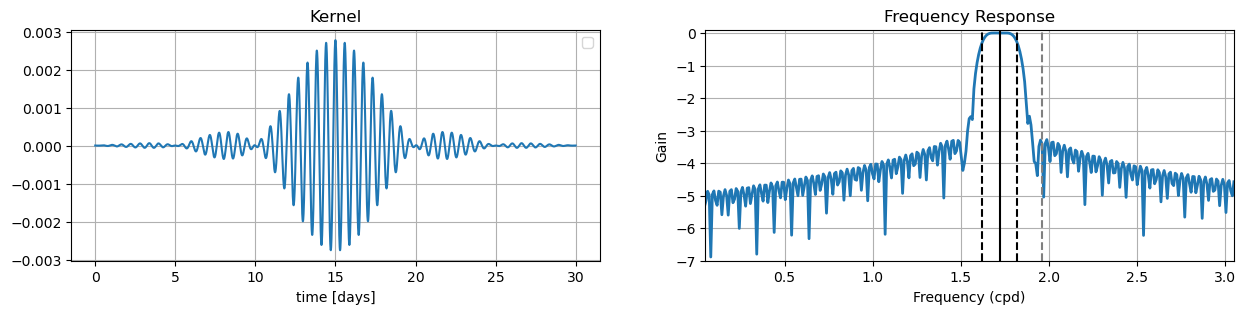

In [9]:
t = np.arange(0,Tw,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega, color='k')
ax.axvline(omega-bandwidth, color='k',ls='--')
ax.axvline(omega+bandwidth, color='k',ls='--')
ax.axvline(1.96, color='grey', ls='--')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [14]:
gridded=xr.open_dataset(root_dir+'M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]

In [15]:
ds = sp.wrap_filter(gridded,h)

In [16]:
rho = 1025
wkb = niskine.clim.get_wkb_factors(gridded)
#ds,wkb = sp.calc_ni_eke(ds)
ds["bp_eke"] = 0.5 * rho * ((wkb * ds.u_filtered) ** 2 + (wkb * ds.v_filtered) ** 2)
ds['ke'] = 0.5*(ds.u**2+ds.v**2)
ds['eke'] = 0.5*((ds.u-ds.u.mean())**2+(ds.v-ds.v.mean())**2)
ds['bpu_wkb'] = ds['u_filtered']*wkb
ds['bpv_wkb'] = ds['v_filtered']*wkb
ds.bp_eke.attrs.update({'long_name':'Kinetic energy', 'units':r'$m^2.s^{-2}$'})
ds.bpu_wkb.attrs.update({'long_name':'Zonal velocity', 'units':r'$m.s^{-1}$'})
ds.bpv_wkb.attrs.update({'long_name':'Meridional velocity', 'units':r'$m.s^{-1}$'})

(<Figure size 1200x500 with 4 Axes>, <Axes: xlabel='time', ylabel='depth [m]'>)

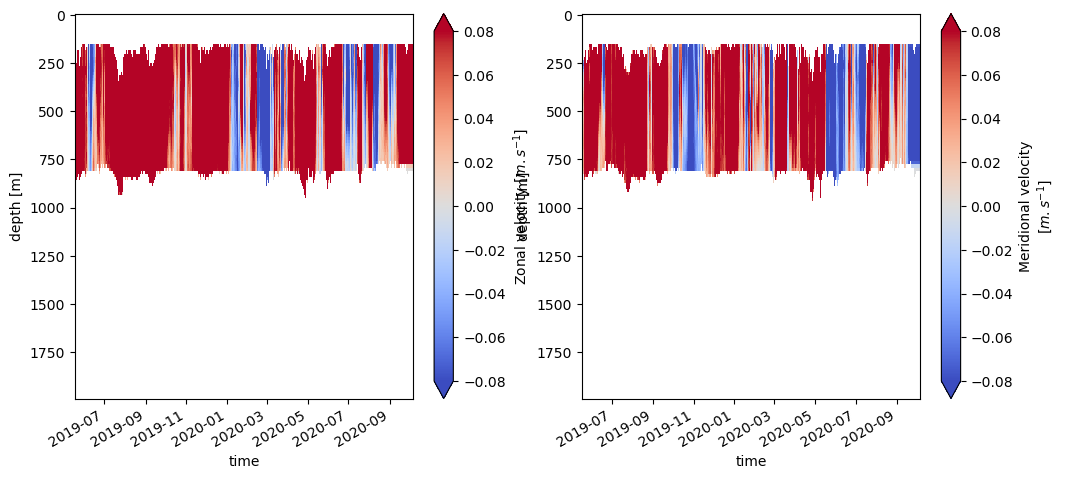

In [17]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
pl.plot_uv(ds,'bpu_wkb',fig,ax,vmax=0.08)

ax = fig.add_subplot(122)
pl.plot_uv(ds,'bpv_wkb',fig,ax,vmax=0.08)

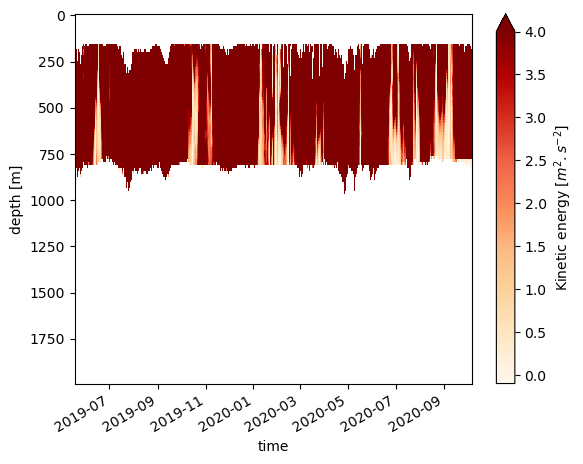

In [18]:
ds.bp_eke.plot(y='z',yincrease=False,vmax=4,vmin=-0.1,cmap='OrRd')

In [19]:
ds.to_netcdf(root_dir+'M%s_lpfiltered.nc'%mooring)